# LSTM - Long Short Term Memory Neural Network

Surgen de la necesidad de conservar información de más tiempo atrás, en redes recurrentes, la información se puede desvanecer tras pocas iteraciones, ya que en el cálculo del gradiente de la capa oculta (en RNN's convencionales) se escala según el gradiente de iteraciones anteriores, desvaneciendo el gradiente en varias iteraciones o, en caso contrario, creciendo de forma exponencial y causando divergencia en el modelo.

La arquitectura de una neurona utilizada en LSTM, llamada $\textit{célula}$, cuenta con combinaciones de compuertas con una respectiva función de activación:

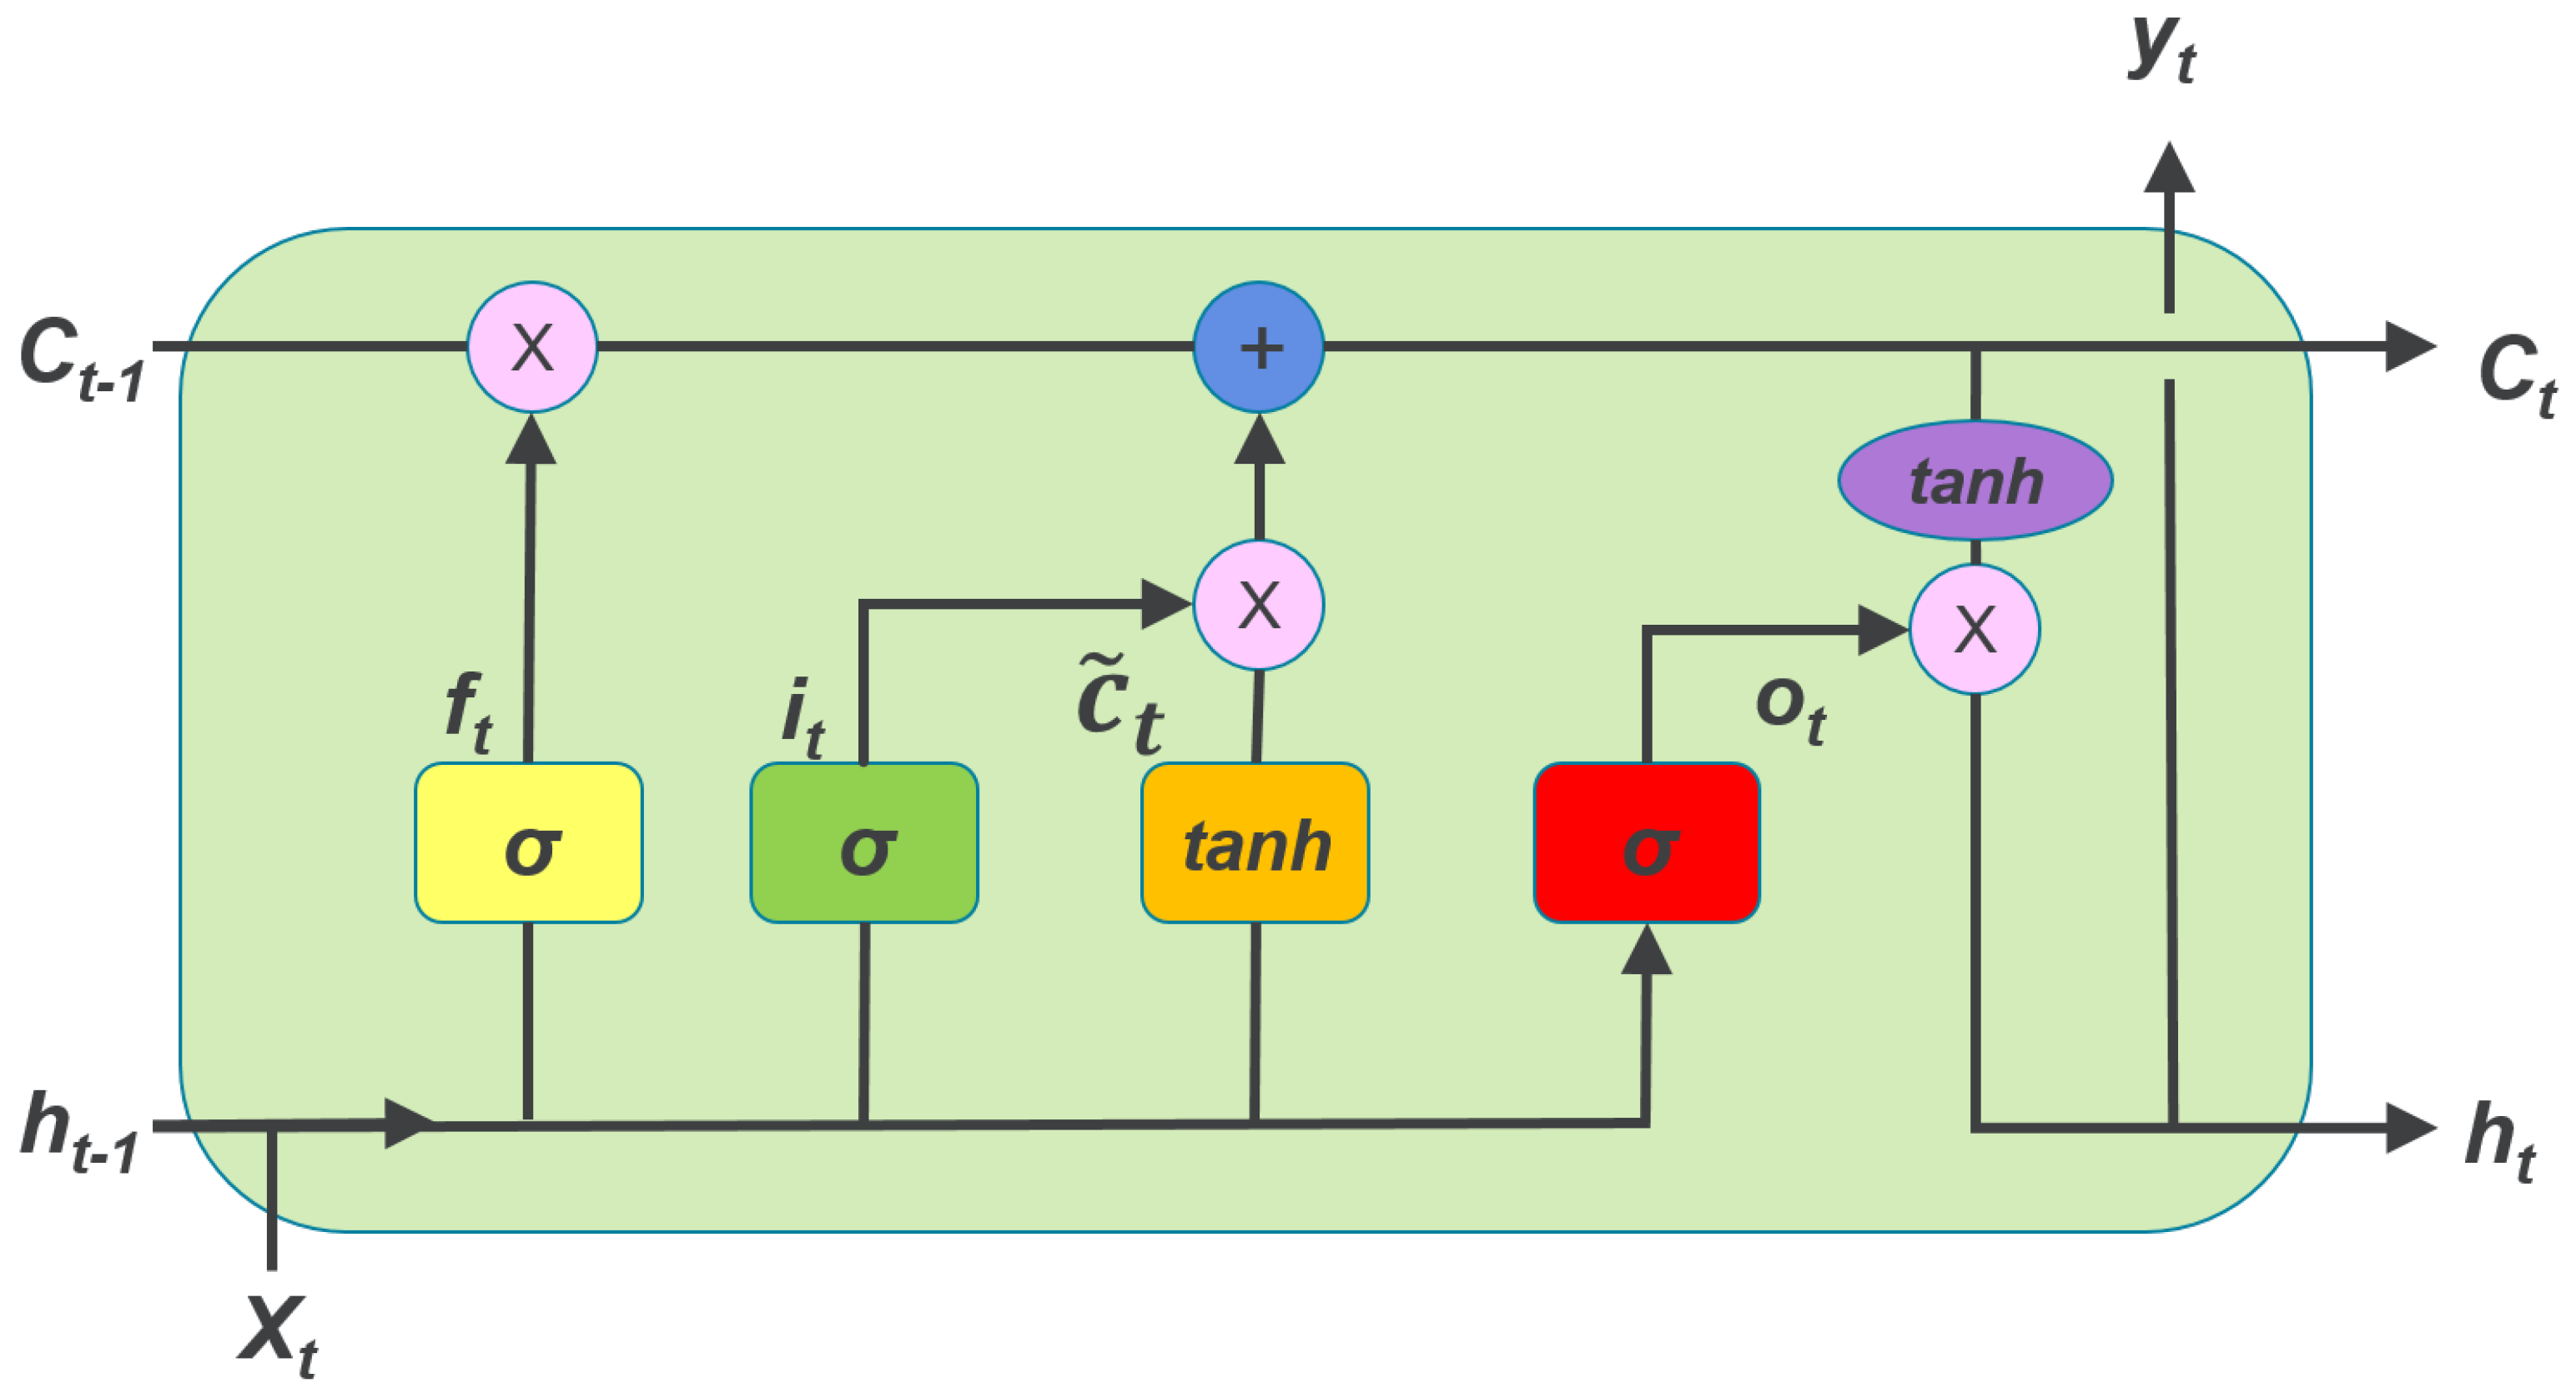

In [1]:
from IPython.display import Image
Image(filename='img/LSTM_Cell.png', width=800)

La entrada actual $X_t$ y la información de la salida de la capa oculta del tiempo anterior $h_{t-1}$ pasan por varios perceptrones con función de activación sigmoide (gates) y uno de tangente hiperbólica.

$f_t$ determina si la neurona "olvida" o no la información al multiplicarse con el estado anterior $C_{t-1}$, mientras que $i_t$ define si la información del dato candidato $\tilde{C}_t$ debe combinarse con la información del estado anterior, esto produce el nuevo estado $C_t$.

Finalmente, la compuerta $o_t$ pondera cuánta información de este proceso es transmitida a la salida de la red neuronal $y_t$ y se utiliza además como información de la capa oculta actual $h_t$ para ser utilizada en la siguiente observación.

El proceso de esta célula se basa en un filtro móvil exponencial de la forma $\mu^t \leftarrow \beta\mu^{(t-1)}+(1-\beta)v^{(t)}$, ponderado por el parámetro $\beta$ que determinará la importancia del dato pasado ($t=t-1$) de manera inversamente proporcional al dato actual ($t$).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
np.random.seed(666)

#Se define una función cualquiera y se le agrega ruido
x = np.arange(0, 3, 0.01)
y = np.sin(2*np.pi*x)
y += np.random.rand(x.size)

In [3]:
@interact(Beta = (0., 1., 0.1))

def plotGraph(Beta):
    # global x, y
    plt.figure(figsize=(10,6))
    plt.plot(x, y, 'b', alpha=0.5, label="Original")

    #Se define una copia de la función y se le aplica un filtro móvil exponencial
    y2 = np.copy(y)
    for i in range(1, x.size): 
        y2[i] = Beta * y2[i-1] + (1 - Beta) * y[i]

    plotLabel="Beta = " + str(Beta)
    
    plt.plot(x, y2, 'r', alpha= 0.5, label=plotLabel)
    plt.legend(loc=2)
    plt.grid()
    plt.show()

interactive(children=(FloatSlider(value=0.5, description='Beta', max=1.0), Output()), _dom_classes=('widget-in…

## Aplcación de LSTM a un conjunto de datos

### 1. Valor de la acción de Coca-Cola

In [4]:
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
import math
from sklearn.metrics import mean_squared_error

In [5]:
#Esta celda es por problemas de compatibilidad con la GPU en la última actualización

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [6]:
dataset = pd.read_csv('datasets/KO_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,20.40,20.50,20.18,20.45,13640800,KO
2006-01-04,20.50,20.54,20.33,20.41,19993200,KO
2006-01-05,20.36,20.56,20.29,20.51,16613400,KO
2006-01-06,20.53,20.78,20.43,20.70,17122800,KO
2006-01-09,20.74,20.84,20.62,20.80,13819800,KO


In [7]:
# Checking for missing values

#Obtener datos hasta 2015 de columna High para entrenamiento
training_set = dataset[:'2015'].iloc[:,1:2].values

#Obtener datos desde 2016 de columna High para prueba
test_set = dataset['2016':].iloc[:,1:2].values

#Donde el dato sea NaN, asignar valor máximo
test_set[np.isnan(test_set)] = dataset['High'].max()

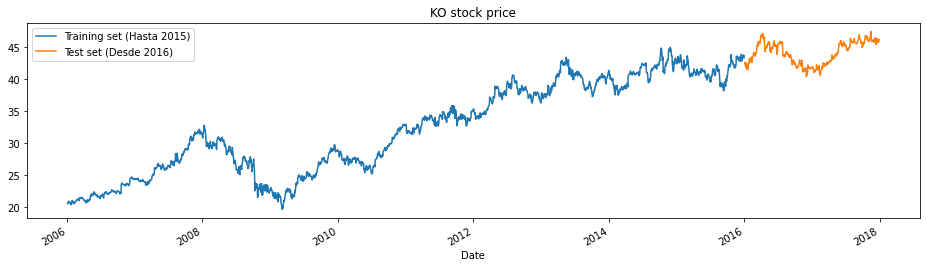

In [8]:
# Gráfica del atributo High para train y test
dataset["High"][:'2015'].plot(figsize=(16,4),legend=True)
dataset["High"]['2016':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Hasta 2015)','Test set (Desde 2016)'])
plt.title('KO stock price')
plt.show()

In [9]:
# Se normalizan los datos con MinMaxScaler entre 0 y 1
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [10]:
from lib.DataPreparationRNN import create_dataset
look_back = 10
X_train, y_train = create_dataset(training_set_scaled, look_back)
print(X_train.shape)
print(y_train.shape)

(2507, 10)
(2507,)


In [11]:
# The LSTM architecture
regressor = Sequential()
# Una capa LSTM con Dropout del 30% seguido de una densa
regressor.add(LSTM(units=50, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.3))
regressor.add(Dense(units=1))

In [12]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


El modelo que utiliza la red LSTM produce más parámetros en comparación con una red neuronal recurrente convencional, esto produce incremento en el tiempo de entrenamiento y costo computacional

**Nota:** en volúmenes de datos suficientemente grandes, el uso de las LSTM puede presentar mejor desempeño que el modelo "intermedio" de *Gated Recurrent Unit*, que hace uso de menos parámetros.

*LSTM > GRU > RNN*

In [13]:
# Compilación del modelo LSTM
regressor.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train.reshape(X_train.shape[0],look_back,1),y_train,epochs=50,batch_size=32)

Epoch 1/50
79/79 [==============================] - 2s 4ms/step - loss: 0.0516
Epoch 2/50
79/79 [==============================] - 0s 4ms/step - loss: 0.0066
Epoch 3/50
79/79 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 4/50
79/79 [==============================] - 0s 4ms/step - loss: 0.0042
Epoch 5/50
79/79 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 6/50
79/79 [==============================] - 0s 4ms/step - loss: 0.0039
Epoch 7/50
79/79 [==============================] - 0s 4ms/step - loss: 0.0036
Epoch 8/50
79/79 [==============================] - 0s 4ms/step - loss: 0.0034
Epoch 9/50
79/79 [==============================] - 0s 4ms/step - loss: 0.0032
Epoch 10/50
79/79 [==============================] - 0s 4ms/step - loss: 0.0033
Epoch 11/50
79/79 [==============================] - 0s 4ms/step - loss: 0.0032
Epoch 12/50
79/79 [==============================] - 0s 4ms/step - loss: 0.0029
Epoch 13/50
79/79 [==============================

In [14]:
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - look_back:].values
inputs[np.isnan(inputs)] = dataset['High'].max()
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)
inputs.shape

(513, 1)

In [15]:
# Preparación de X_test
X_test = []
for i in range(look_back,inputs.shape[0]):
    X_test.append(inputs[i-look_back:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [16]:
# Predicciones obtenidas
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

16/16 [==============================] - 0s 1ms/step


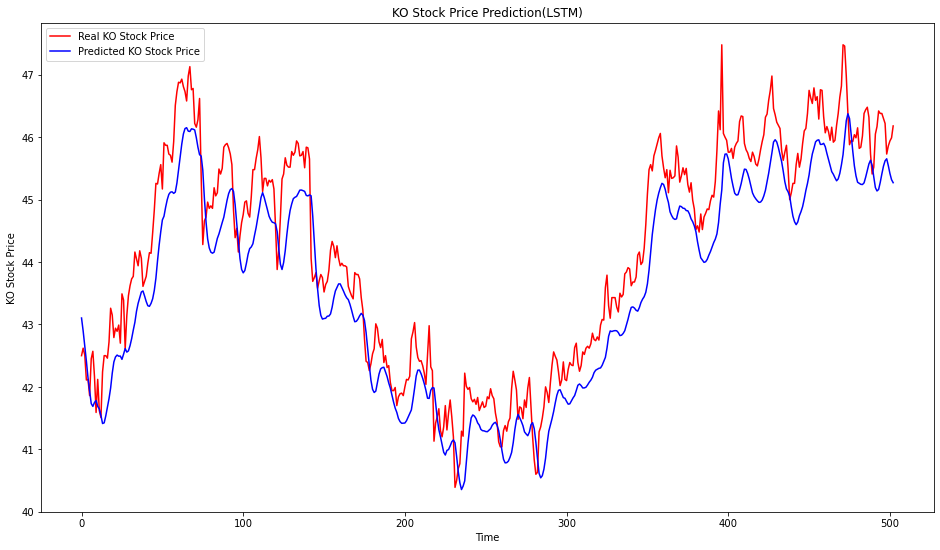

In [17]:
# Gráfico de resultados
plt.figure(figsize=(16,9))
plt.plot(test_set, color='red',label='Real KO Stock Price')
plt.plot(predicted_stock_price, color='blue',label='Predicted KO Stock Price')
plt.title('KO Stock Price Prediction(LSTM)')
plt.xlabel('Time')
plt.ylabel('KO Stock Price')
plt.legend()
plt.show()

In [18]:
# Evaluación del modelo mediante RMSE
rmse = math.sqrt(mean_squared_error(test_set, predicted_stock_price))
print("El error de raíz cuadrática media es {}.".format(rmse))

El error de raíz cuadrática media es 0.7242589727466351.
